In [136]:
# !pip install pillow
# !pip install opencv-python
# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install tensorflow==2.10
# !pip install scikit-learn

**Ini merupakan project computer vision untuk deteksi kantuk pengemudi kendaraan yang menggunakan algoritma Convolutional Neural Network (CNN) dengan pengimplementasian 3 macam Transfer Learning menggunakan library tensorflow**

Dataset: https://www.kaggle.com/datasets/hazemfahmy/openned-closed-eyes/data

by Hazem Fahmy

**Tentang Dataset**

Selamat datang di Dataset Deteksi Kantuk UnityEyes! Dataset komprehensif ini dirancang untuk membantu para peneliti dan pengembang dalam tugas penting deteksi kantuk, yang secara khusus berfokus pada identifikasi pengemudi yang mengantuk berdasarkan perilaku mata. Dataset ini dikumpulkan menggunakan UnityEyes, sebuah simulator sintetis mata yang canggih, untuk memastikan data berkualitas tinggi. Data tersebut diberi label menggunakan ambang batas keterbukaan = 20 (referensi: https://github.com/SNTSVV/HUDD-Toolset)

Dataset Deteksi Mengantuk terdiri dari beragam koleksi rekaman gerakan mata dari subjek dengan demografi yang berbeda-beda, yang diambil dalam skenario mengemudi yang terkendali. Data tersebut mencakup urutan gambar mata, yang diberi label secara cermat untuk menunjukkan apakah mata terbuka atau tertutup, yang berfungsi sebagai kebenaran dasar untuk mendeteksi pengemudi yang mengantuk.

## **Import Library**

In [137]:
import os
import random
import numpy as np
import pandas as pd
from PIL import  Image
import string

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)

2.10.0


In [138]:
import warnings
# Abaikan semua warning
warnings.filterwarnings('ignore')

Beberapa fungsi library yang digunakan:
- **os**: Untuk mengoperasikan sistem operasi.
- **cv2**: OpenCV untuk tugas-tugas computer vision.
- **PIL**: Library pencitraan Python untuk tugas-tugas pemrosesan gambar.
- **numpy**: Untuk komputasi numerik dan matriks.
- **matplotlib.pyplot**: Untuk visualisasi plot.
- **seaborn**: Untuk visualisasi plot.
- **sklearn**: Untuk preprocessing data dan evaluasi akurasi
- **tensorflow**: Untuk membangun dan melatih model pembelajaran mesin.

## **Load Data from Directory**

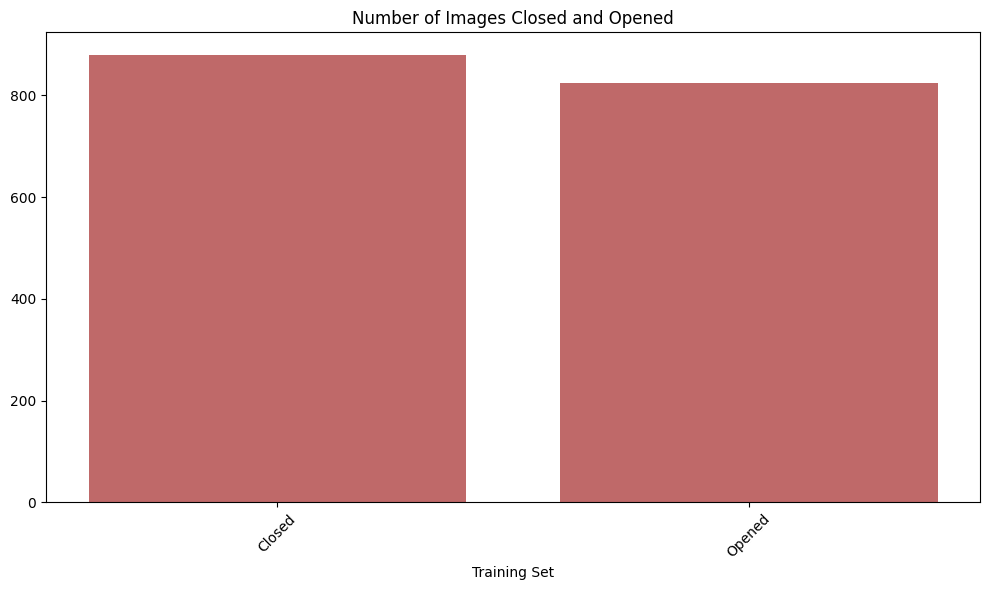

In [139]:
# directory yang mengandung Image
root_dir = './drownisess/TrainingSet/TrainingSet'

# Iterasi melalui setiap folder di direktori root
folder_image_count = {}

for data in os.listdir(root_dir):
    path_folder = os.path.join(root_dir, data)
    if os.path.isdir(path_folder):
        # Menghitung jumlah file gambar di dalam folder
        num_images = len([name for name in os.listdir(path_folder) if os.path.isfile(os.path.join(path_folder, name)) and name.lower().endswith(('.png', '.jpg', '.jpeg'))])
        folder_image_count[data] = num_images

# Extract nama folder dan jumlah gambar yang sesuai
folders = list(folder_image_count.keys())
img_counts = list(folder_image_count.values())

# Plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(folders)), img_counts, color = 'brown', align='center', alpha=0.7)
plt.xticks(range(len(folders)), folders, rotation=45)
plt.xlabel('Training Set')
plt.title('Number of Images Closed and Opened')
plt.tight_layout()
plt.show()

Setelah melakukan exttact data dari direktori path yang telah ditentukan, di dapatkan data Training Set yang terdiri dari 2 data mata Terbuka dengan 824 gambar dan mata Mengantuk dengan 880 gambar. Pastikan folder dataset berada ditempat yang sama seperti folder .py atau jupyter anda.

Contoh direktori yang benar:

**Project**

----- **drownisess**
 
----- **drownisess-detection.ipynb**

## **Preprocessing Data**

Setelah dilakukan extract data, akan dilakukan transform data. Dataset akan dikelompokan berdasarkan label masing-masing lalu dilakukan resize image untuk mengcompress gambar mnejadi ukuran 150x150 dengan 3 channel warna karena merupakan gambar RGB.

In [140]:
categories = ['Opened', 'Closed'] # Folder yang akan dimuat
image_size = (150, 150) # Untuk setting ukuran gambar

# Inisialisasi list untuk menyimpan data dan label
X = []
Y = []

# Memuat gambar dan label dari setiap folder
for label, category in enumerate(categories):
    folder_path = os.path.join(root_dir, category)
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img = img.resize(image_size)  # Mengubah ukuran gambar
            img_array = np.array(img)     # Mengonversi gambar menjadi array numpy
            X.append(img_array)
            Y.append(label)

# Mengonversi list X dan Y menjadi array numpy
X = np.array(X)
Y = np.array(Y)

Label mata terbuka **“Opened”: 0** dan Label mata mengantuk **“Closed”: 1**

In [141]:
print(f'Total gambar: {len(X)}')
print(f'Total label: {len(Y)}')
print('kode label:', np.unique(Y))

Total gambar: 1704
Total label: 1704
kode label: [0 1]


In [142]:
X[0]

array([[[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       ...,

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]],

       [[98, 98, 98],
        [98, 98, 98],
        [98, 98, 98],
        ...,
        [98, 98, 98],
        [98, 98, 98],
        [98, 98, 98]]], dtype=uint8)

Melakukan load data yang telah di extract dan di transform untuk melihat 5 sampel masing-masing setiap label

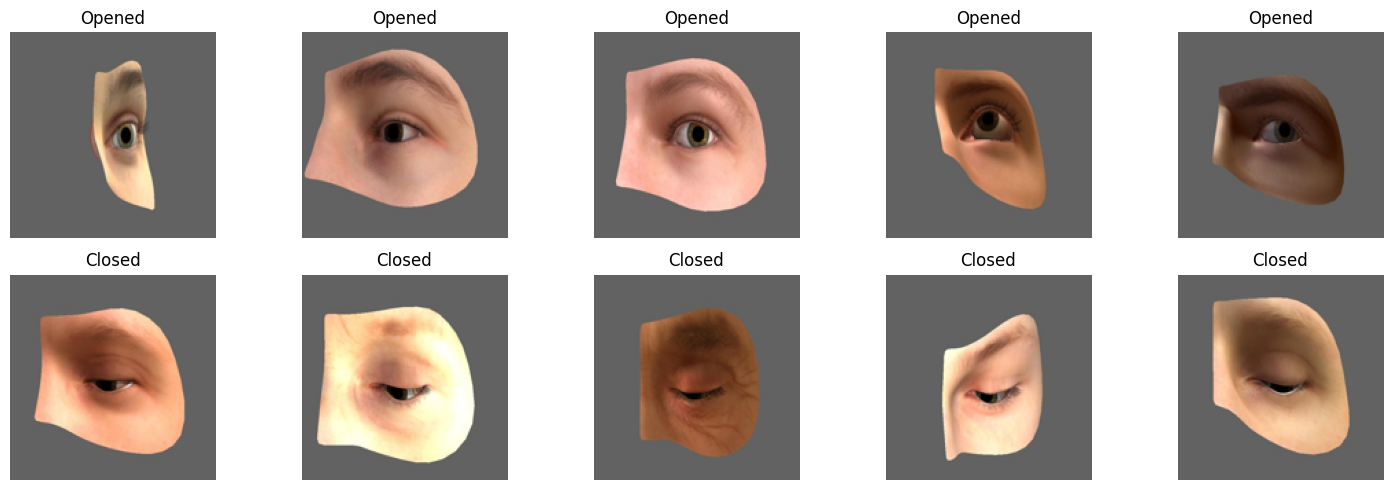

In [143]:
# Memisahkan gambar berdasarkan label
X_opened = X[Y == 0]
X_closed = X[Y == 1]

# Mengambil 5 sampel acak dari masing-masing kategori
opened_samples = np.random.choice(len(X_opened), 5, replace=False)
closed_samples = np.random.choice(len(X_closed), 5, replace=False)

X_samples = np.concatenate((X_opened[opened_samples], X_closed[closed_samples]))
Y_samples = np.concatenate((np.zeros(5), np.ones(5)))

# Menampilkan 10 sampel gambar
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_samples[i])
    plt.title('Opened' if Y_samples[i] == 0 else 'Closed')
    plt.axis('off')
plt.tight_layout()
plt.show()

Membagi data menjadi data training 90% dan data validation 10%

In [144]:
x_train, x_validation, y_train, y_validation = train_test_split(X, Y, test_size=0.1, random_state=79)

In [145]:
print(x_train.shape)
print(y_train.shape)

(1533, 150, 150, 3)
(1533,)


terdapat 1533 gambar untuk data training

In [146]:
print(x_validation.shape)
print(y_validation.shape)

(171, 150, 150, 3)
(171,)


terdapat 171 gambar untuk data validation

In [147]:
# Mengonversi y_train dan y_validation menjadi kategorikal (one-hot encoded vectors.)
y_train = to_categorical(y_train, num_classes=2)
y_validation = to_categorical(y_validation, num_classes=2)

## **Model CNN**

Model pertama adalah model CNN tanpa transfer learning dengan 1 dropout lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik

In [148]:
# Define jumlah kelas
num_classes = 2

# Input layer
inputs = Input(shape=(150, 150, 3))

# Layer 1
x = Conv2D(32, (3, 3), padding='same')(inputs)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(32, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(64, (3, 3), padding='same')(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Flatten layer untuk convert the 3D feature maps menjadi 1D
x = Flatten()(x)

# Dense layer dengan 64 neurons dan ReLU activation
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
x = Dense(num_classes)(x)
outputs = Activation('softmax')(x)

# Membuat model
model = Model(inputs=inputs, outputs=outputs)

# Melakukan compile dengan categorical crossentropy loss, Adam optimizer, & accuracy metrik
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Membuat checkpoint callback uuntuk menyimpan best model based berdasarkan validation accuracy
checkpointCNN = ModelCheckpoint('best_model_CNN.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Training model
batch_size = 32  # Define your batch size
historyCNN = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        verbose=1, 
                        epochs=20, 
                        validation_data=(x_validation, y_validation), 
                        shuffle=False,
                        callbacks=[checkpointCNN])

Epoch 1/20
45/48 [===========================>..] - ETA: 0s - loss: 14.8097 - accuracy: 0.7083
Epoch 1: val_accuracy improved from -inf to 0.91813, saving model to best_model_CNN.h5
48/48 [==============================] - 1s 19ms/step - loss: 13.9295 - accuracy: 0.7195 - val_loss: 0.2527 - val_accuracy: 0.9181
Epoch 2/20
47/48 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9295
Epoch 2: val_accuracy improved from 0.91813 to 0.96491, saving model to best_model_CNN.h5
48/48 [==============================] - 1s 17ms/step - loss: 0.2039 - accuracy: 0.9302 - val_loss: 0.1262 - val_accuracy: 0.9649
Epoch 3/20
46/48 [===========================>..] - ETA: 0s - loss: 0.1363 - accuracy: 0.9490
Epoch 3: val_accuracy improved from 0.96491 to 0.97076, saving model to best_model_CNN.h5
48/48 [==============================] - 1s 17ms/step - loss: 0.1346 - accuracy: 0.9498 - val_loss: 0.0916 - val_accuracy: 0.9708
Epoch 4/20
45/48 [===========================>..] - ETA: 0s

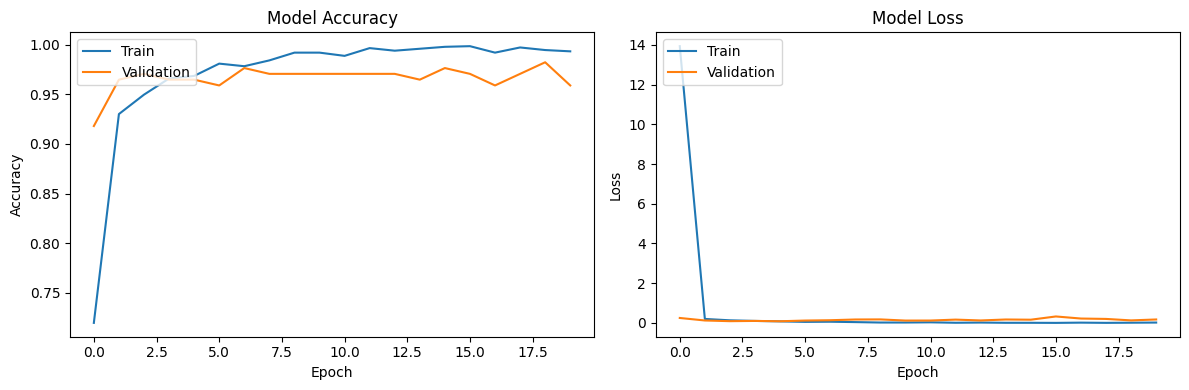

In [149]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyCNN.history['accuracy'])
ax1.plot(historyCNN.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyCNN.history['loss'])
ax2.plot(historyCNN.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [150]:
# Evaluasi akurasi dan loss pada set validation
validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation, verbose=1)
print(f'validation accuracy: {validation_accuracy*100:.3f}%')
print(f'validation loss: {validation_loss:.4f}')

# Memprediksi label pada set validation
y_pred = model.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification_report
class_report = classification_report(y_true, y_pred_classes, target_names=categories)
print('Classification Report:')
print(class_report)

1/6 [====>.........................] - ETA: 0s - loss: 0.3053 - accuracy: 0.9062

6/6 [==============================] - 0s 5ms/step - loss: 0.1771 - accuracy: 0.9591
validation accuracy: 95.906%
validation loss: 0.1771
6/6 [==============================] - 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

      Opened       0.95      0.97      0.96        87
      Closed       0.96      0.95      0.96        84

    accuracy                           0.96       171
   macro avg       0.96      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



Validation Akurasi yang didapatkan model ini sebesar 95.9% dan F1-Score yang dihasilkan sebesar 96% untuk model CNN tanpa transfer learning, setekah itu melihat confusion matriks untuk melihat berapa data yang dapat ditebak dengan tepat dan tidak tepat

Confusion Matrix:
[[84  3]
 [ 4 80]]


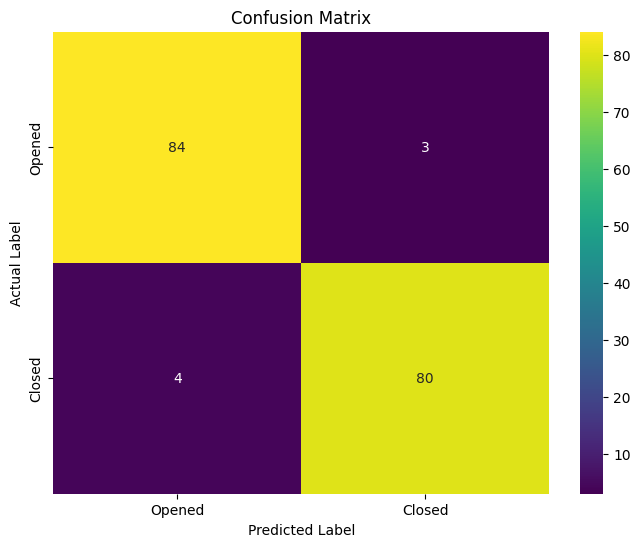

In [151]:
# Membuat confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

## **Predict the New Data with CNN**

melakukan predict data dengan gambar baru pada foldet Test Set untuk melihat prediksi pada data yang belum pernah dikenali model

1/1 [==============================] - 0s 12ms/step


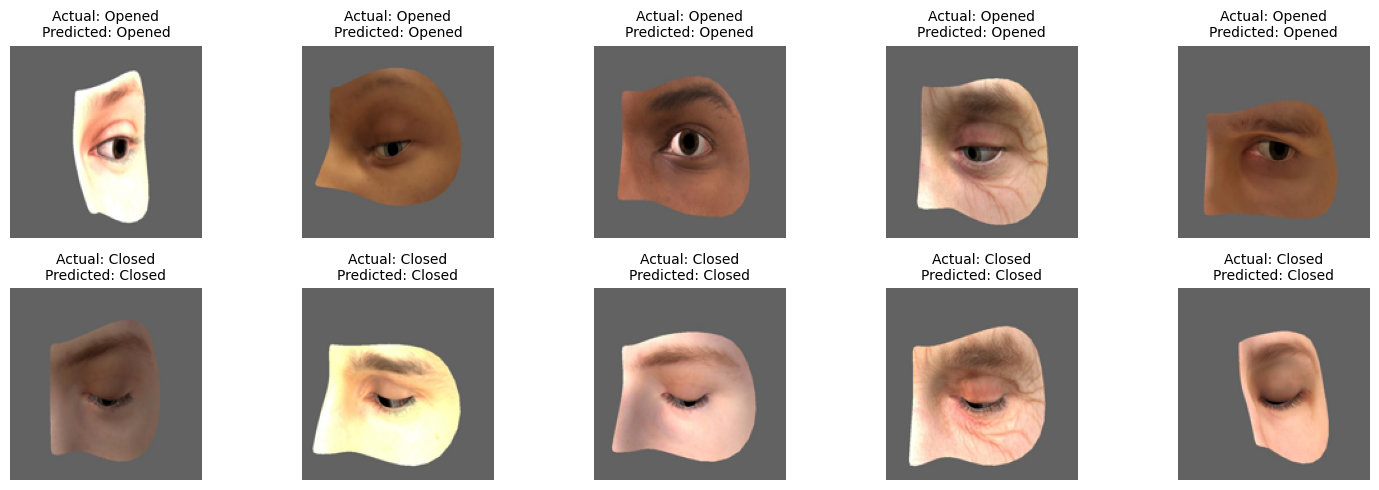

In [152]:
# Load model .h5
model = tf.keras.models.load_model('best_model_CNN.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

# Membuat list categories
categories = ['Opened', 'Closed']

# Inisialisasi lists untuk store images (X) dan label yang ada (Y)
X_samples = []
Y_samples = []

# preprocess images
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    # Shuffle image untuk memastikan gambar dirandom
    random.shuffle(image_files)
    #Mengambil 5 image setelah di shuffle
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

# Convert lists ke numpy
X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model EfficientNetV2S**

Model kedua adalah model CNN dengan memakai model EfficientNetV2 Small dengan menambah 1 dropout lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik

In [153]:
base_model = tf.keras.applications.EfficientNetV2S(
    include_top = False,
    weights = 'imagenet',
    input_tensor = None,
    input_shape = (150, 150, 3),
    pooling = None,
    classes = 2,
    include_preprocessing = True
)

# Freeze model transfer learning dengan trainable = False
base_model.trainable = False

# Membuat input layer dengan shape yang sesuai
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

# membuat model
model = Model(inputs, outputs)

# Melakukan compile dengan categorical crossentropy loss, Adam optimizer, & accuracy metrik
model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

# Membuat checkpoint callback uuntuk menyimpan best model based berdasarkan validation accuracy
checkpointV2S = ModelCheckpoint('best_model_V2S.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

# Training model
batch_size = 32
historyV2S = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=20, 
                        validation_data=(x_validation, y_validation), 
                        callbacks=[checkpointV2S],
                        verbose = 1)


Epoch 1/20
47/48 [============================>.] - ETA: 0s - loss: 0.3064 - accuracy: 0.8684
Epoch 1: val_accuracy improved from -inf to 0.88304, saving model to best_model_V2S.h5
48/48 [==============================] - 10s 81ms/step - loss: 0.3051 - accuracy: 0.8682 - val_loss: 0.2430 - val_accuracy: 0.8830
Epoch 2/20
47/48 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9255
Epoch 2: val_accuracy improved from 0.88304 to 0.91813, saving model to best_model_V2S.h5
48/48 [==============================] - 2s 50ms/step - loss: 0.1876 - accuracy: 0.9256 - val_loss: 0.1903 - val_accuracy: 0.9181
Epoch 3/20
47/48 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9309
Epoch 3: val_accuracy improved from 0.91813 to 0.93567, saving model to best_model_V2S.h5
48/48 [==============================] - 2s 50ms/step - loss: 0.1728 - accuracy: 0.9309 - val_loss: 0.1735 - val_accuracy: 0.9357
Epoch 4/20
47/48 [============================>.] - ETA: 0s 

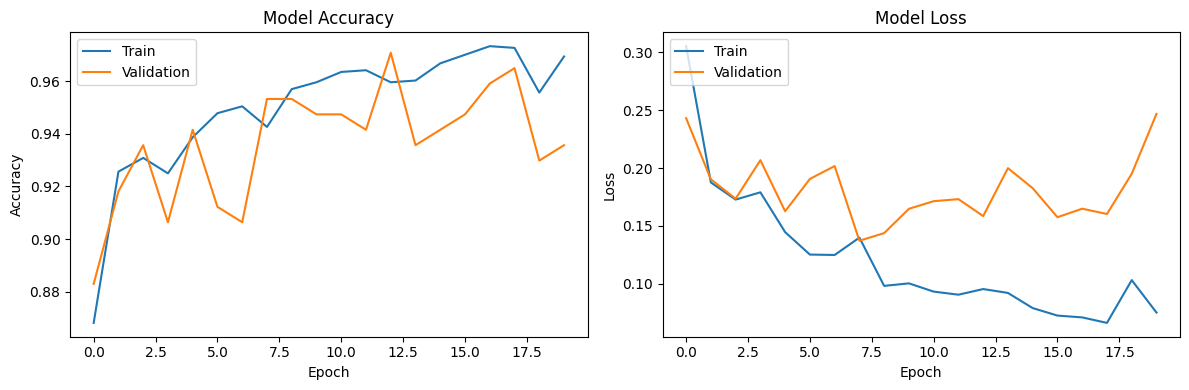

In [154]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyV2S.history['accuracy'])
ax1.plot(historyV2S.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyV2S.history['loss'])
ax2.plot(historyV2S.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [155]:
# Evaluasi akurasi dan loss pada set validation
loss, accuracy = model.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Generate classification report
y_pred = model.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=categories))

6/6 [==============================] - 0s 33ms/step - loss: 0.2467 - accuracy: 0.9357
validation accuracy: 93.567%
validation loss: 0.2467
6/6 [==============================] - 2s 35ms/step
Classification Report:
              precision    recall  f1-score   support

      Opened       1.00      0.87      0.93        87
      Closed       0.88      1.00      0.94        84

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171



Validation Akurasi yang didapatkan model ini sebesar 93.5% dan F1-Score yang dihasilkan sebesar 94% untuk model CNN dengan pre-trained EfficientNetV2 Small, setelah itu melihat confusion matriks untuk melihat berapa data yang dapat ditebak dengan tepat dan tidak tepat

Confusion Matrix:
[[76 11]
 [ 0 84]]


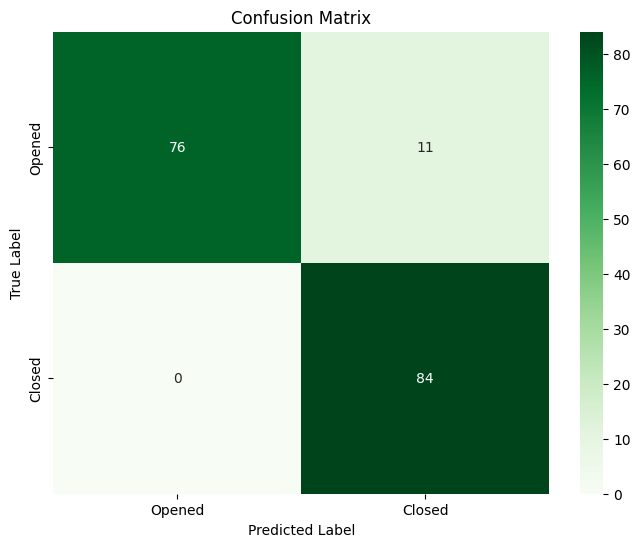

In [156]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Predict the New Data with EfficientNetV2S**

1/1 [==============================] - 0s 19ms/step


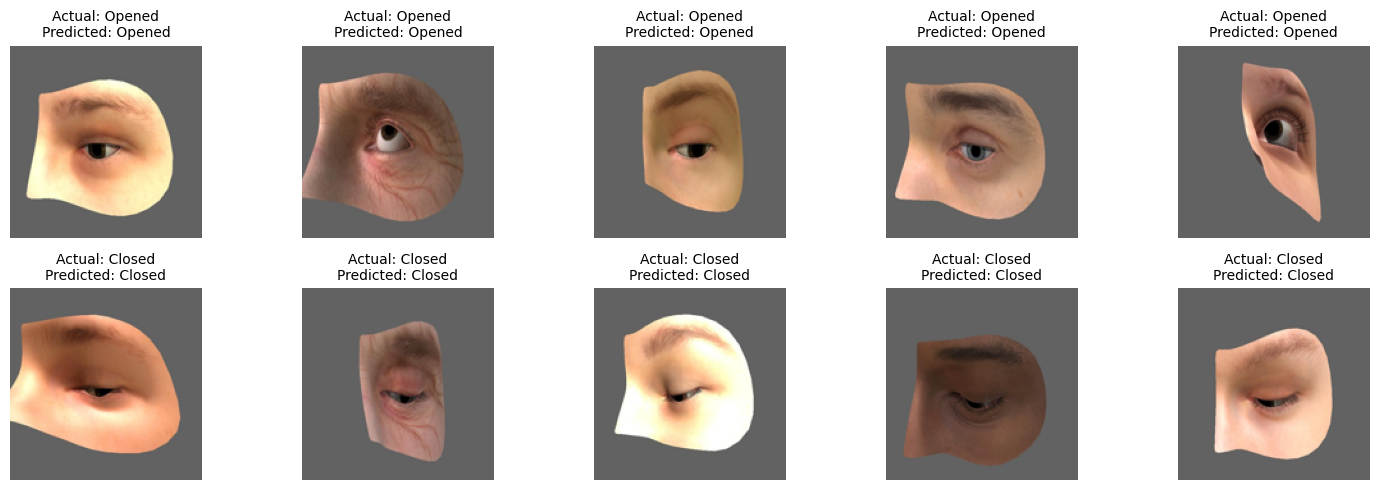

In [157]:
# Load model .h5
model = tf.keras.models.load_model('best_model_V2S.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)
    return img_array


for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model VGG16**

Model kedua adalah model CNN dengan memakai model VGG16 dengan menambah 1 dropout lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik

In [158]:
tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape = (150, 150, 3),
    pooling=None,
    classes=2,
)

# Freeze model transfer learning dengan trainable = False
base_model.trainable = False

# Membuat input layer dengan shape yang sesuai
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

checkpointVGG19 = ModelCheckpoint('best_model_VGG19.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

batch_size = 32
historyVGG19 = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=20, 
                        validation_data=(x_validation, y_validation), 
                        callbacks=[checkpointVGG19],
                        verbose = 1)


Epoch 1/20
47/48 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8703
Epoch 1: val_accuracy improved from -inf to 0.84795, saving model to best_model_VGG19.h5
48/48 [==============================] - 9s 82ms/step - loss: 0.2864 - accuracy: 0.8702 - val_loss: 0.2631 - val_accuracy: 0.8480
Epoch 2/20
47/48 [============================>.] - ETA: 0s - loss: 0.1923 - accuracy: 0.9209
Epoch 2: val_accuracy improved from 0.84795 to 0.92982, saving model to best_model_VGG19.h5
48/48 [==============================] - 2s 51ms/step - loss: 0.1907 - accuracy: 0.9211 - val_loss: 0.1784 - val_accuracy: 0.9298
Epoch 3/20
47/48 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9289
Epoch 3: val_accuracy did not improve from 0.92982
48/48 [==============================] - 2s 42ms/step - loss: 0.1802 - accuracy: 0.9282 - val_loss: 0.1878 - val_accuracy: 0.9298
Epoch 4/20
47/48 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9328
Ep

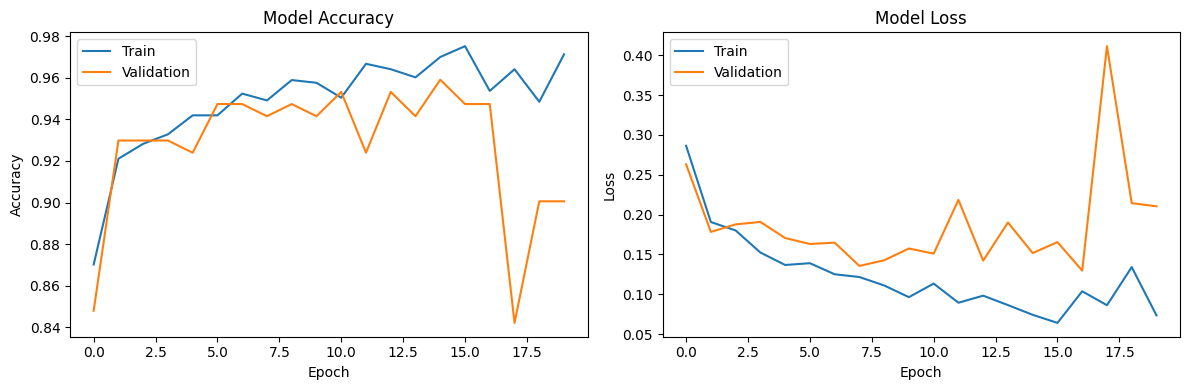

In [159]:
# Plot loss & akurasi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation akurasi
ax1.plot(historyVGG19.history['accuracy'])
ax1.plot(historyVGG19.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(historyVGG19.history['loss'])
ax2.plot(historyVGG19.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [160]:
# Evaluate model
loss, accuracy = model.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Memprediksi label pada set validation
y_pred = model.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=categories))

6/6 [==============================] - 0s 33ms/step - loss: 0.2105 - accuracy: 0.9006
validation accuracy: 90.058%
validation loss: 0.2105
6/6 [==============================] - 3s 73ms/step
Classification Report:
              precision    recall  f1-score   support

      Opened       0.85      0.98      0.91        87
      Closed       0.97      0.82      0.89        84

    accuracy                           0.90       171
   macro avg       0.91      0.90      0.90       171
weighted avg       0.91      0.90      0.90       171



Validation Akurasi yang didapatkan model ini sebesar 90% dan F1-Score yang dihasilkan sebesar 90% untuk model CNN dengan pre-trained VGG16, setelah itu melihat confusion matriks untuk melihat berapa data yang dapat ditebak dengan tepat dan tidak tepat

Confusion Matrix:
[[85  2]
 [15 69]]


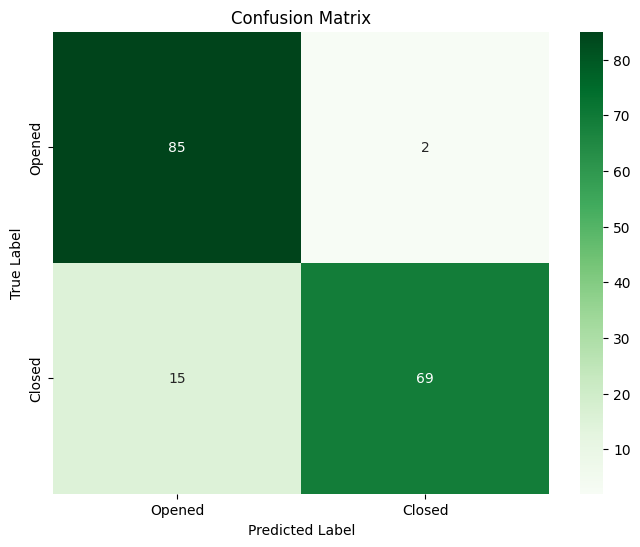

In [161]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Predict the New Data with VGG19**

1/1 [==============================] - 0s 19ms/step


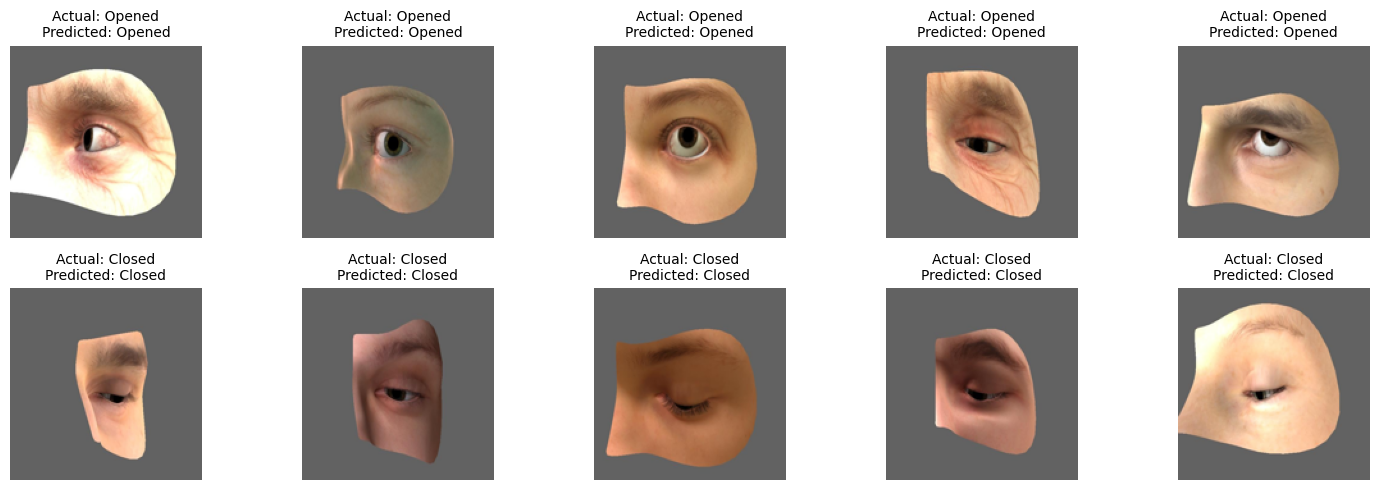

In [162]:
# Load model .h5
model = tf.keras.models.load_model('best_model_VGG19.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150)) 
    img_array = np.array(img)      
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]
    
    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):
    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Model InceptionResNetV2**

Model kedua adalah model CNN dengan memakai model InceptionResNetV2 dengan menambah 1 dropout lalu menginisialisasi Checkpoint Callback untuk menyimpan model dengan validation akurasi terbaik

In [163]:
tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
    classes=2,
)

# Freeze model transfer learning dengan trainable = False
base_model.trainable = False

# Membuat input layer dengan shape yang sesuai
inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
# Output layer dengan softmax activation untuk multi-class classification dengan jumlah neuron sama dengan jumlah kelas
outputs = Dense(num_classes, activation = 'softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

checkpointIRNV2 = ModelCheckpoint('best_model_IRNV2.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

batch_size = 32
historyIRNV2 = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=20, 
                        validation_data=(x_validation, y_validation), 
                        callbacks=[checkpointIRNV2],
                        verbose = 1)


Epoch 1/20
47/48 [============================>.] - ETA: 0s - loss: 3.0443 - accuracy: 0.8132
Epoch 1: val_accuracy improved from -inf to 0.90058, saving model to best_model_IRNV2.h5
48/48 [==============================] - 9s 86ms/step - loss: 3.0216 - accuracy: 0.8141 - val_loss: 1.4038 - val_accuracy: 0.9006
Epoch 2/20
47/48 [============================>.] - ETA: 0s - loss: 0.6436 - accuracy: 0.9003
Epoch 2: val_accuracy improved from 0.90058 to 0.94152, saving model to best_model_IRNV2.h5
48/48 [==============================] - 3s 55ms/step - loss: 0.6439 - accuracy: 0.8995 - val_loss: 0.2421 - val_accuracy: 0.9415
Epoch 3/20
47/48 [============================>.] - ETA: 0s - loss: 0.2019 - accuracy: 0.9362
Epoch 3: val_accuracy improved from 0.94152 to 0.94737, saving model to best_model_IRNV2.h5
48/48 [==============================] - 3s 55ms/step - loss: 0.1988 - accuracy: 0.9374 - val_loss: 0.1755 - val_accuracy: 0.9474
Epoch 4/20
47/48 [============================>.] - ETA

In [164]:
# Evaluate model
loss, accuracy = model.evaluate(x_validation, y_validation)
print(f'validation accuracy: {accuracy*100:.3f}%')
print(f'validation loss: {loss:.4f}')

# Memprediksi label pada set validation
y_pred = model.predict(x_validation)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_validation, axis=1)

# Membuat classification report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes, target_names=categories))

6/6 [==============================] - 0s 33ms/step - loss: 0.1492 - accuracy: 0.9649
validation accuracy: 96.491%
validation loss: 0.1492
6/6 [==============================] - 2s 35ms/step
Classification Report:
              precision    recall  f1-score   support

      Opened       0.99      0.94      0.96        87
      Closed       0.94      0.99      0.97        84

    accuracy                           0.96       171
   macro avg       0.97      0.97      0.96       171
weighted avg       0.97      0.96      0.96       171



Validation Akurasi yang didapatkan model ini sebesar 96,5% dan F1-Score yang dihasilkan sebesar 96% untuk model CNN dengan pre-trained InceptionResNetV2, setekah itu melihat confusion matriks untuk melihat berapa data yang dapat ditebak dengan tepat dan tidak tepat

Confusion Matrix:
[[82  5]
 [ 1 83]]


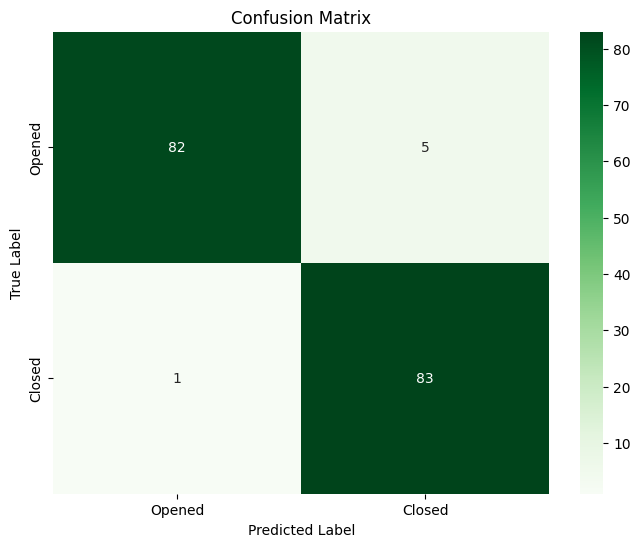

In [165]:
# Plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **Predict the New Data with InceptionResNetV2**

1/1 [==============================] - 0s 21ms/step


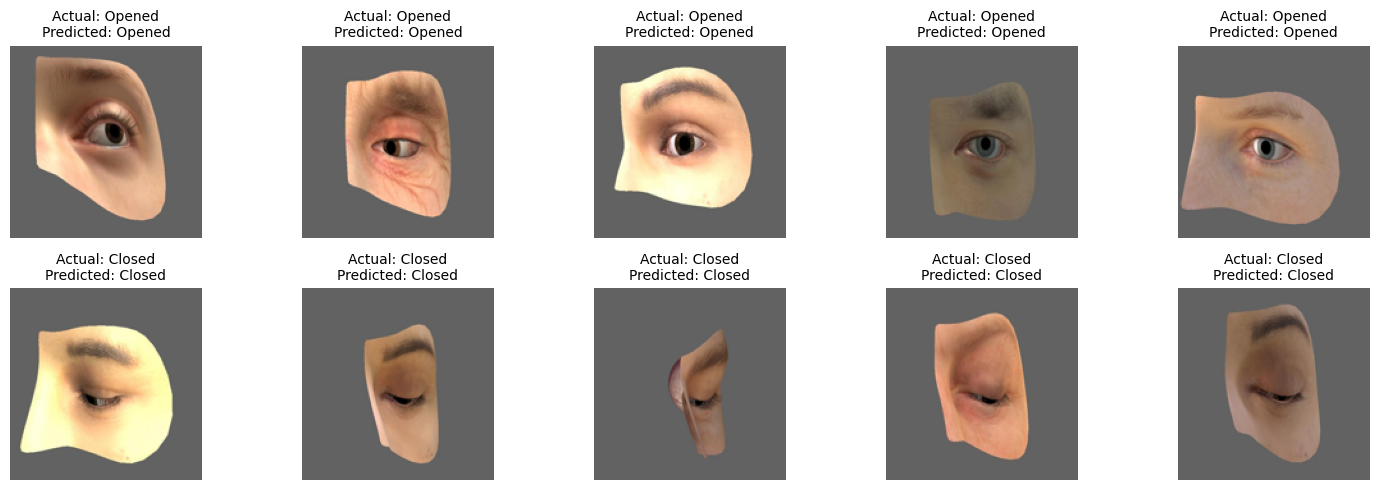

In [169]:
# Load model .h5
model = tf.keras.models.load_model('best_model_IRNV2.h5')

# directory yang mengandung Image test
test_dir = './drownisess/TestSet/TestSet'

categories = ['Opened', 'Closed']

X_samples = []
Y_samples = []

def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((150, 150))  
    img_array = np.array(img)      
    return img_array

for category in categories:
    folder_path = os.path.join(test_dir, category)
    image_files = os.listdir(folder_path)
    random.shuffle(image_files)
    selected_images = image_files[:5]

    for image_file in selected_images:
        image_path = os.path.join(folder_path, image_file)
        img_array = preprocess_image(image_path)
        X_samples.append(img_array)
        if category == 'Opened':
            Y_samples.append(0)
        else:
            Y_samples.append(1)

X_samples = np.array(X_samples)
Y_samples = np.array(Y_samples)

num_samples = 10
num_cols = 5
num_rows = num_samples // num_cols

plt.figure(figsize=(15, 5))
for i in range(num_samples):

    current_image = X_samples[i]
    actual_label = Y_samples[i]

    batch_prediction = model.predict(np.expand_dims(current_image, axis=0))
    predicted_label = np.argmax(batch_prediction)

    disease_labels = ['Opened', 'Closed']

    predicted_class = disease_labels[predicted_label]

    actual_class = disease_labels[actual_label]

    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(current_image)
    plt.axis('off')
    plt.title("Actual: {}\nPredicted: {}".format(actual_class, predicted_class), fontsize=10)

plt.tight_layout()
plt.show()

## **Kesimpulan**

Pada project Computer Vision ini menggunakan algoritma Convolutional Neural Network yang disertai 3 pre-trained model yaitu EfficientNetV2S, VGG16, dan InceptionResNetV2. Keempat model ini dapat dibandingkan untuk melihat model mana yang menghasilkan akurasi paling baik. Berikut adalah hasil perbadingan akurasi dari keempat model:

1. Model CNN ============================================> Validation Acc: 95.9% ; F1-Score: 96%
2. Model CNN dengan pre-trained EfficientMNetV2 Small ================> Validation Acc: 93.5% ; F1-Score: 94%
3. Model CNN dengan pre-trained VGG16 ==========================> Validation Acc: 90.0% ; F1-Score: 90%
4. Model CNN dengan pre-trained InceptionResNetV2 ==================> Validation Acc: 96.5% ; F1-Score: 96%

Seluruh model tidak memiliki overvitting maupun underfitting yang ditunjukan dari plot visualisasi loss dan akurasi data training dan validation. Oleh karena itu model CNN dengan pre-trained InceptionResNetV2 menjadi model paling baik untuk dataset model kantuk ini.

Untuk pemodelan lebih lanjut, data pada folder TrainingSet dapat ditambahkan data dari ImprovementSet untuk memperbanyak data dan bisa menambah akurasi yang dihasilkan nantinya.